<a href="https://colab.research.google.com/github/ArnavKetkar/PortfolioProjects/blob/main/Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
file_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(file_path), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 0s 0us/step


In [3]:
file_path

'/root/.keras/datasets/cats_and_dogs.zip'

In [4]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [5]:
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            seed = 0)

Found 2000 files belonging to 2 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 seed=0,
                                                                 shuffle=True)

Found 1000 files belonging to 2 classes.


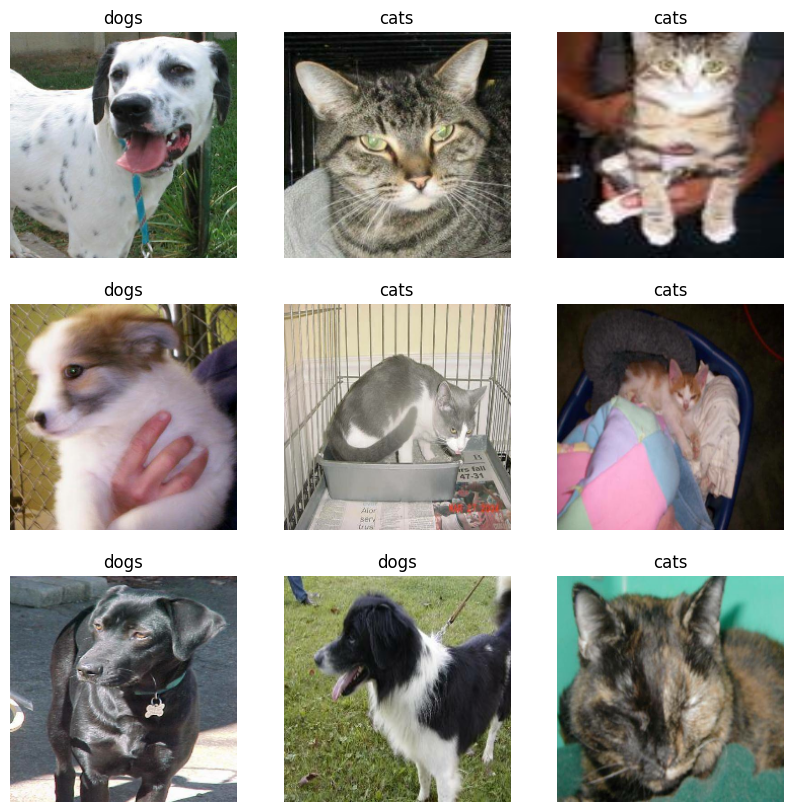

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [10]:
num_val_batches = tf.data.experimental.cardinality(validation_dataset)

test_dataset = validation_dataset.take(num_val_batches//5)
validation_dataset = validation_dataset.skip(num_val_batches//5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)])

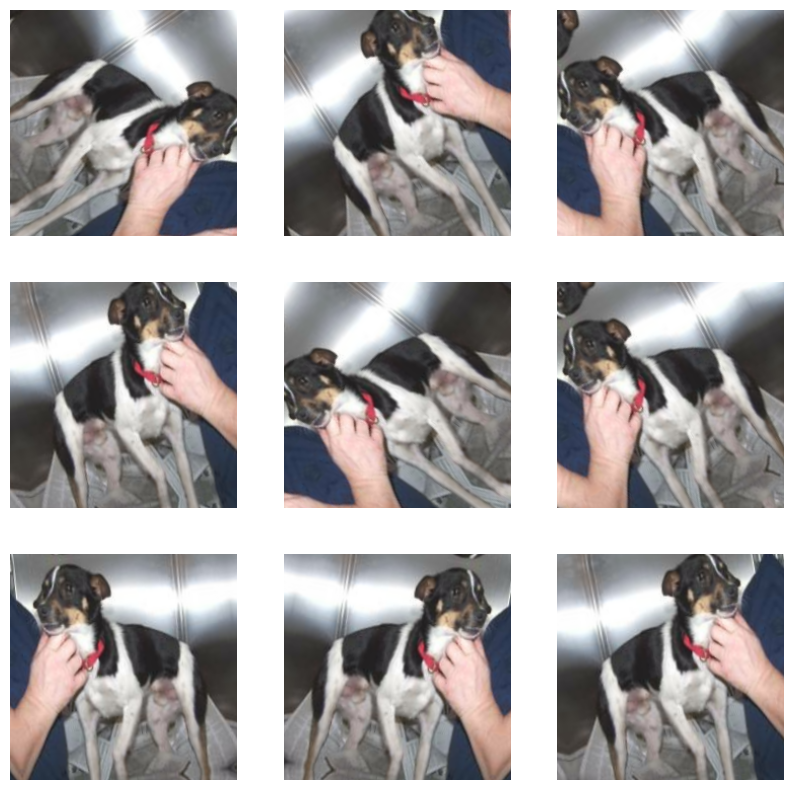

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  first_image = images[0]
  for i in range(9):
    plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation(np.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255.)
    plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
IMG_SHAPE = IMG_SIZE + (3, )

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_average_layer(feature_batch)
print(feature_batch_avg.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_avg)
prediction_batch.shape

TensorShape([32, 1])

In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [23]:
base_lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [25]:
len(model.trainable_variables)# W and b

2

In [26]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 66ms/step - loss: 0.7876 - accuracy: 0.4864


In [27]:
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

Initial loss: 0.79
Initial accuracy: 0.49


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 11s 105ms/step - loss: 0.6837 - accuracy: 0.5840 - val_loss: 0.5204 - val_accuracy: 0.7153
Epoch 2/10
63/63 [==============================] - 5s 79ms/step - loss: 0.5003 - accuracy: 0.7290 - val_loss: 0.3694 - val_accuracy: 0.8403
Epoch 3/10
63/63 [==============================] - 6s 96ms/step - loss: 0.3779 - accuracy: 0.8270 - val_loss: 0.2744 - val_accuracy: 0.9183
Epoch 4/10
63/63 [==============================] - 6s 95ms/step - loss: 0.3118 - accuracy: 0.8700 - val_loss: 0.2169 - val_accuracy: 0.9369
Epoch 5/10
63/63 [==============================] - 5s 78ms/step - loss: 0.2655 - accuracy: 0.8995 - val_loss: 0.1854 - val_accuracy: 0.9505
Epoch 6/10
63/63 [==============================] - 6s 96ms/step - loss: 0.2465 - accuracy: 0.9015 - val_loss: 0.1608 - val_accuracy: 0.9554
Epoch 7/10
63/63 [==============================] - 5s 79ms/step - loss: 0.2157 - accuracy: 0.9190 - val_loss: 0.1387 - val_accuracy: 0.9653
Epoch 8/10


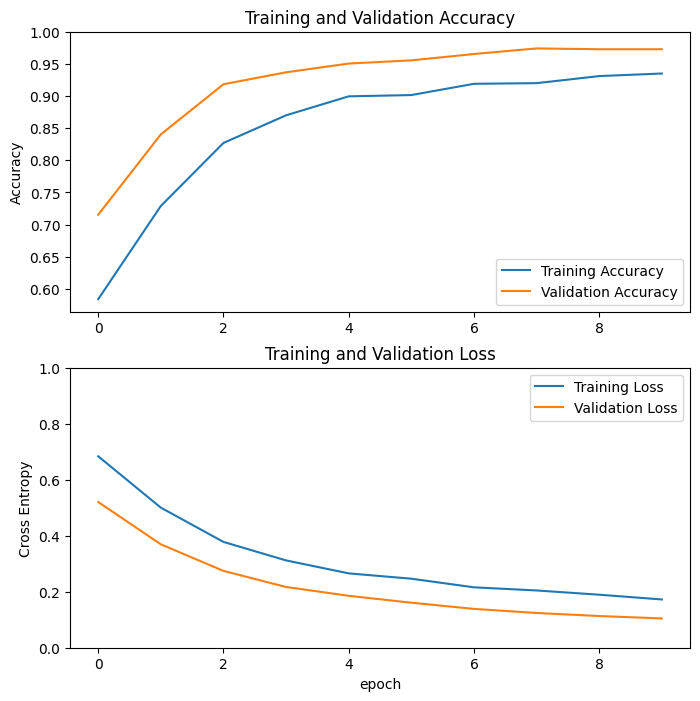

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
# Fine Tuning should be done only after top-level classifier with pre-trained model is trained.

In [31]:
base_model.trainable = True

In [32]:
print("There are %d layers in base model" % len(base_model.layers))

fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

There are 154 layers in base model


In [33]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr/10),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [35]:
len(model.trainable_variables)

38

In [36]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         validation_data=validation_dataset,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1])

Epoch 10/20
63/63 [==============================] - 18s 118ms/step - loss: 0.1152 - accuracy: 0.9560 - val_loss: 0.0361 - val_accuracy: 0.9889
Epoch 11/20
63/63 [==============================] - 7s 100ms/step - loss: 0.0978 - accuracy: 0.9610 - val_loss: 0.0362 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 6s 86ms/step - loss: 0.0745 - accuracy: 0.9705 - val_loss: 0.0216 - val_accuracy: 0.9901
Epoch 13/20
63/63 [==============================] - 7s 97ms/step - loss: 0.0769 - accuracy: 0.9735 - val_loss: 0.0254 - val_accuracy: 0.9913
Epoch 14/20
63/63 [==============================] - 7s 100ms/step - loss: 0.0647 - accuracy: 0.9755 - val_loss: 0.0268 - val_accuracy: 0.9889
Epoch 15/20
63/63 [==============================] - 6s 85ms/step - loss: 0.0649 - accuracy: 0.9750 - val_loss: 0.0204 - val_accuracy: 0.9926
Epoch 16/20
63/63 [==============================] - 7s 102ms/step - loss: 0.0554 - accuracy: 0.9795 - val_loss: 0.0218 - val_accuracy: 0.9913
E

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

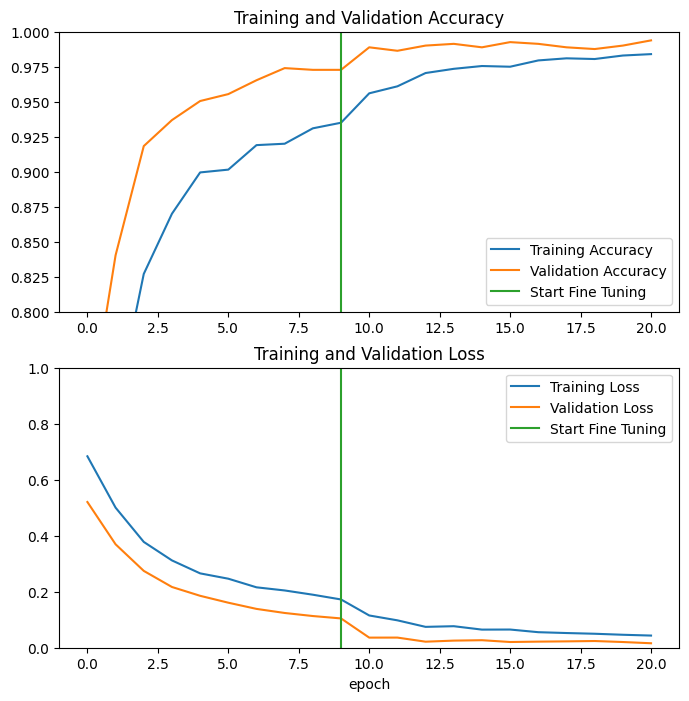

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print("Test Accuracy :", accuracy)

6/6 [==============================] - 1s 57ms/step - loss: 0.0189 - accuracy: 0.9948
Test Accuracy : 0.9947916865348816


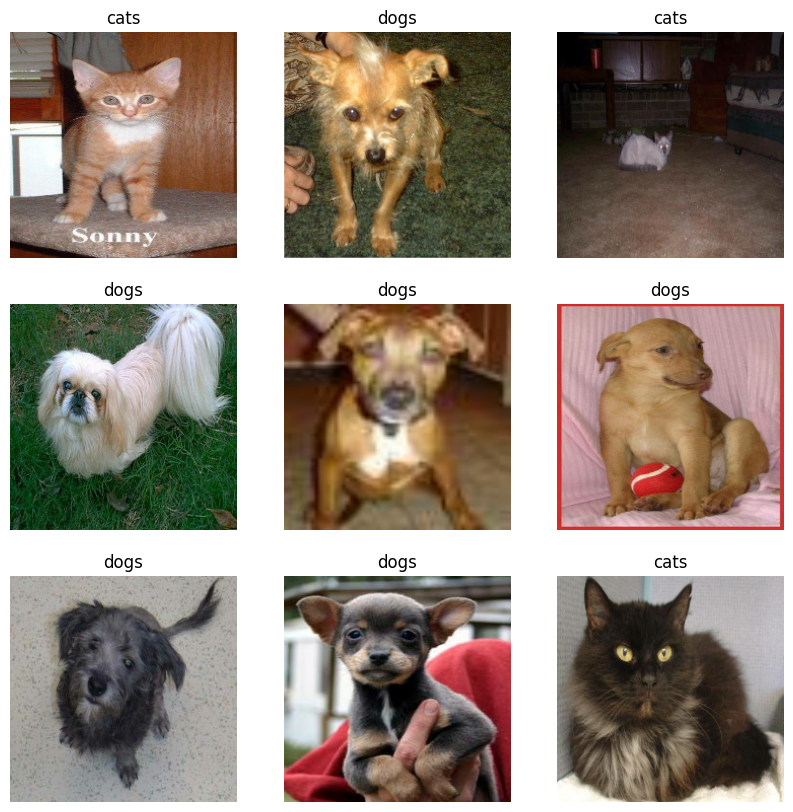

In [40]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions<0.5, 0, 1)

plt.figure(figsize = (10, 10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(class_names[predictions[i]])
  plt.axis('off')